In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

(CVXPY) Nov 26 01:18:57 AM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: 找不到指定的模块。')


C:\Users\Terry_Xu\AppData\Local\Temp\ipykernel_38768\1659410565.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
df_ori = pd.read_csv('./data/close.csv', sep=',')
df_ori['cash'] = 1
# df_ori = pd.read_csv('./data/close_390.csv', sep=',')
df_ori.head()

,Date,AAPL,AMZN,JNJ,JPM,LLY,MSFT,NVDA,PG,UNH,XOM,cash
0,2003-11-18,0.364464,2.4250,51.939999,34.889999,70.940002,25.150000,1.639167,47.830002,24.549999,35.150002,1
1,2003-11-19,0.364643,2.4765,52.259998,34.759998,72.540001,25.350000,1.685000,48.040001,25.790001,35.439999,1
2,2003-11-20,0.363929,2.4425,51.490002,34.630001,71.529999,25.100000,1.640000,47.705002,25.400000,35.310001,1
3,2003-11-21,0.362143,2.4290,50.880001,35.000000,69.610001,25.110001,1.646667,47.880001,25.860001,35.340000,1
4,2003-11-24,0.377679,2.5665,51.480000,35.270000,70.500000,25.730000,1.745833,48.310001,26.400000,35.560001,1


In [3]:
df_ori.set_index('Date', inplace=True)
df_ori.index = pd.DatetimeIndex(df_ori.index)
ENDTIME = pd.to_datetime('2008-12-31')
df_ori = df_ori.loc[df_ori.index <= ENDTIME]
df_ori.tail()

,AAPL,AMZN,JNJ,JPM,LLY,MSFT,NVDA,PG,UNH,XOM,cash
Date,,,,,,,,,,,
2008-12-24,3.037143,2.572,58.560001,29.850000,37.799999,19.170000,1.9300,60.389999,25.959999,75.779999,1
2008-12-26,3.064643,2.589,58.560001,29.799999,37.980000,19.129999,1.8775,60.529999,26.299999,77.190002,1
2008-12-29,3.093214,2.470,58.150002,29.780001,38.480000,18.959999,1.9375,60.200001,25.570000,78.019997,1
2008-12-30,3.081786,2.538,59.169998,31.010000,39.669998,19.340000,2.0050,61.119999,27.040001,78.589996,1
2008-12-31,3.048214,2.564,59.830002,31.530001,40.270000,19.440001,2.0175,61.820000,26.600000,79.830002,1


In [4]:
df = df_ori.pct_change().iloc[1:,:]
df.head()

,AAPL,AMZN,JNJ,JPM,LLY,MSFT,NVDA,PG,UNH,XOM,cash
Date,,,,,,,,,,,
2003-11-19,0.000491,0.021237,0.006161,-0.003726,0.022554,0.007952,0.027961,0.004391,0.050509,0.008250,0.0
2003-11-20,-0.001958,-0.013729,-0.014734,-0.003740,-0.013923,-0.009862,-0.026706,-0.006973,-0.015122,-0.003668,0.0
2003-11-21,-0.004908,-0.005527,-0.011847,0.010684,-0.026842,0.000398,0.004065,0.003668,0.018110,0.000850,0.0
2003-11-24,0.042900,0.056608,0.011792,0.007714,0.012786,0.024691,0.060222,0.008981,0.020882,0.006225,0.0
2003-11-25,-0.022223,0.022209,-0.015346,0.007372,0.002411,-0.012825,0.017184,0.002587,0.019508,0.007312,0.0


In [5]:
def equally_weighted(df):
    arr_pfl = [1]
    cur_pfl = 1
    cur_stg = np.array([1 / len(df.columns)] * len(df.columns))
    # print(cur_stg)

    for i in range(len(df)):
        cur_pfl = cur_pfl * np.dot(cur_stg, 1 + df.iloc[i,:].values)
        arr_pfl.append(cur_pfl)

    return arr_pfl

arr_equal = equally_weighted(df)

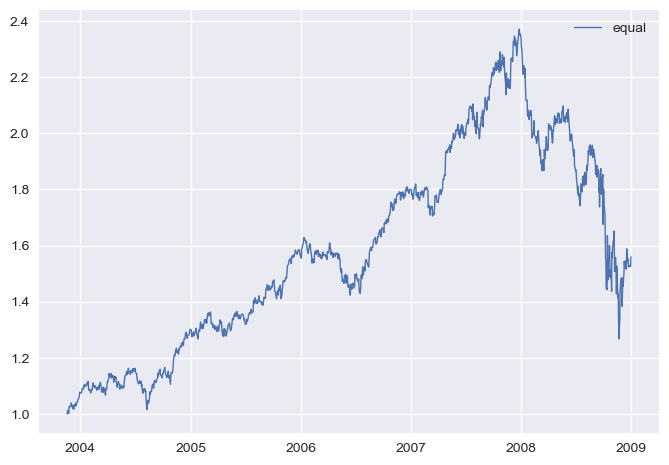

In [6]:
plt.figure()
# plt.plot(df.index, arr_pfl[:-1], linewidth=0.5, label='OGD')
plt.plot(df.index, arr_equal[:-1], linewidth=1, label='equal')
plt.legend(loc='best')
plt.show()

In [ ]:
def OGD_update(x_old, ETA, loss, num_of_var):
    x = cp.Variable(num_of_var, nonneg=True)
    # x = cp.Variable(num_of_var, nonneg=False)
    objective = cp.Minimize(ETA * np.array(loss) @ x + 0.5 * cp.sum((x - x_old) ** 2))
    constraints = [cp.sum(x) == 1]
    prob = cp.Problem(objective, constraints)
    result = prob.solve()

    return x.value
def OGD_algo(df, ETA):
    